In [1]:
import itertools
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import torchvision
import array


import datetime
import time
from pathlib import Path
from typing import Dict, List, Optional, Union

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import utils as vutils


from myDataloader import EMnistDataset
#from models import *
#from datasets import *
from utils import *
from PIL import Image

In [2]:
train_label_filepath = r'data/my_train_label.npy'
train_img_filepath = r'data/my_train_img.npy'
test_label_filepath = r'data/my_test_label.npy'
test_img_filepath = r'data/my_test_img.npy'

In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # %%
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(5, 5), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()

In [4]:
checkpoint_root = Path("cycle_GAN_2")
gen_img_root = Path("cycle_GAN_2/images")
weights_root = Path("cycle_GAN_2/weights")
checkpoint_root.mkdir(exist_ok=True)
gen_img_root.mkdir(exist_ok=True)
weights_root.mkdir(exist_ok=True)

# %%
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 50
        self.batch_size = 512
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 100
        self.n_residual_blocks = 9
        self.epoch = 0
        self.lambda_cyc = 10
        self.lambda_id = 5


opt = Parse()

# %%
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(6)
device = torch.device("cuda:6" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(3):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]

            in_features = out_features

        # # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(3):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

device 6 NVIDIA GeForce RTX 3090


In [5]:
GeneratorResNet(input_shape, opt.n_residual_blocks)

NameError: name 'input_shape' is not defined

In [11]:
# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()



input_shape = (opt.channels, opt.img_size, opt.img_size)

# Initialize generator and discriminator
G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
G_BA = GeneratorResNet(input_shape, opt.n_residual_blocks)
D_A = Discriminator(input_shape)
D_B = Discriminator(input_shape)

cuda = torch.cuda.is_available()
if cuda:
    G_AB = G_AB.to(device)
    G_BA = G_BA.to(device)
    D_A = D_A.to(device)
    D_B = D_B.to(device)
    criterion_GAN.to(device)
    criterion_cycle.to(device)
    criterion_identity.to(device)


G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)
# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=opt.lr, betas=(opt.b1, opt.b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

# Buffers of previously generated samples
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()
# Image transformations
transforms_ = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Resize(32)
])

dataloader = DataLoader(
    EMnistDataset(img_dir=train_img_filepath,
                  transform=transforms_),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

val_dataloader = DataLoader(
    EMnistDataset(img_dir=test_img_filepath,
                  transform=transforms_),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

img len: (697932, 28, 28)
img len: (116323, 28, 28)


In [7]:
for i, imgs in enumerate(dataloader):
    print(imgs.shape)
    break

torch.Size([512, 1, 32, 32])


In [16]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = vutils.make_grid(real_A, nrow=5, normalize=True)
    real_B = vutils.make_grid(real_B, nrow=5, normalize=True)
    fake_A = vutils.make_grid(fake_A, nrow=5, normalize=True)
    fake_B = vutils.make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/%s/%s.png" % (opt.dataset_name, batches_done), normalize=False)


# ----------
#  Training
# ----------

prev_time = time.time()
for epoch in range(opt.epoch, opt.n_epochs):
    for i, imgs in enumerate(dataloader):


        # Set model input

        #real_A = torch.randn(imgs.size()).to(device)
        real_A = imgs.to(device)

        np.random.shuffle(imgs.numpy())
        real_B = imgs.to(device)

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        # Identity loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + opt.lambda_cyc * loss_cycle + opt.lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = opt.n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        if batches_done % (opt.sample_interval // 50 + 1) == 0:
            show_images(real_A, fake_B, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
            show_images(real_B, fake_A, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
            sys.stdout.write(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    opt.n_epochs,
                    i,
                    len(dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

        #If at sample interval save image
        if batches_done % opt.sample_interval == 0:
            if batches_done > 10:
                #sample_images(batches_done)
                show_images(real_A, fake_B, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
                show_images(real_B, fake_A, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
                torch.save(G_AB.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G_AB.pth")
                torch.save(G_BA.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G_BA.pth")
                torch.save(D_A.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D_A.pth")
                torch.save(D_B.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D_B.pth")

    # Update learning rates
    # lr_scheduler_G.step()
    # lr_scheduler_D_A.step()
    # lr_scheduler_D_B.step()

RuntimeError: Unable to find a valid cuDNN algorithm to run convolution

In [ ]:
 for i, imgs in enumerate(val_dataloader):
    real_A = imgs.to(device)
    fake_B = G_AB(real_A)
    show_images(real_A, fake_B, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    #show_images(real_B, fake_A, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
    break

In [52]:
!ls -l cycle_GAN_1/images

total 204692
-rwxrwxrwx 1 root root 198079 Dec 19 19:03 'E001B1001 fack_A images.png'
-rwxrwxrwx 1 root root 110275 Dec 19 19:03 'E001B1001 fack_B images.png'
-rwxrwxrwx 1 root root 210716 Dec 19 19:03 'E001B1001 real_A images.png'
-rwxrwxrwx 1 root root  90161 Dec 19 19:03 'E001B1001 real_B images.png'
-rwxrwxrwx 1 root root 191307 Dec 19 18:36 'E001B101 fack_A images.png'
-rwxrwxrwx 1 root root 112664 Dec 19 18:36 'E001B101 fack_B images.png'
-rwxrwxrwx 1 root root 208666 Dec 19 18:36 'E001B101 real_A images.png'
-rwxrwxrwx 1 root root  88783 Dec 19 18:36 'E001B101 real_B images.png'
-rwxrwxrwx 1 root root 200696 Dec 19 19:06 'E001B1101 fack_A images.png'
-rwxrwxrwx 1 root root 106398 Dec 19 19:06 'E001B1101 fack_B images.png'
-rwxrwxrwx 1 root root 206105 Dec 19 19:06 'E001B1101 real_A images.png'
-rwxrwxrwx 1 root root  92526 Dec 19 19:06 'E001B1101 real_B images.png'
-rwxrwxrwx 1 root root 196633 Dec 19 19:09 'E001B1201 fack_A images.png'
-rwxrwxrwx 1 root root 102655 Dec 19 19:09

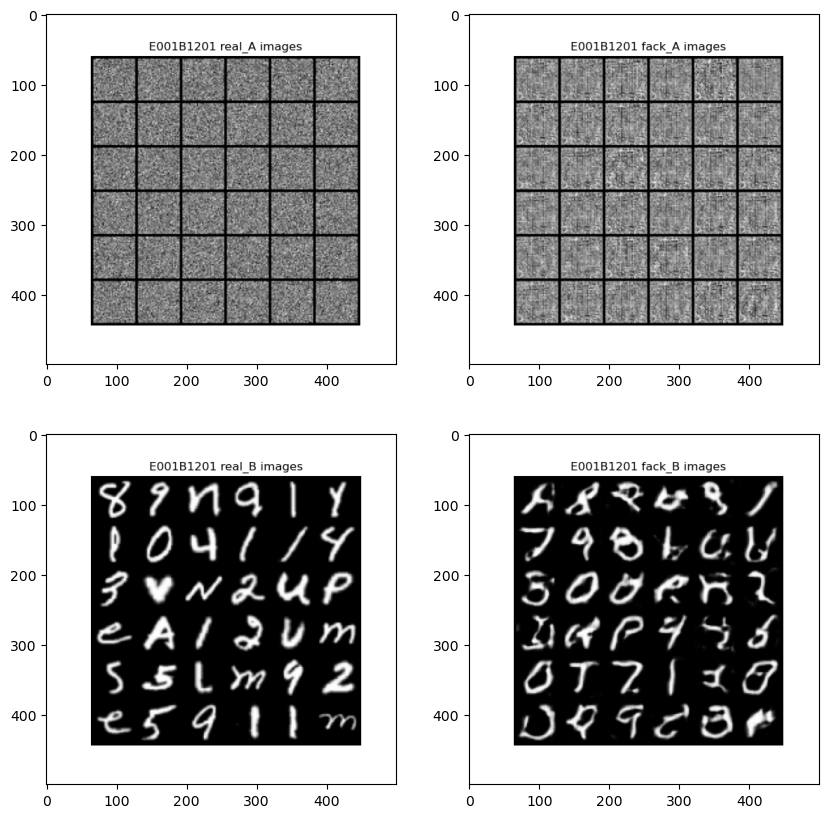

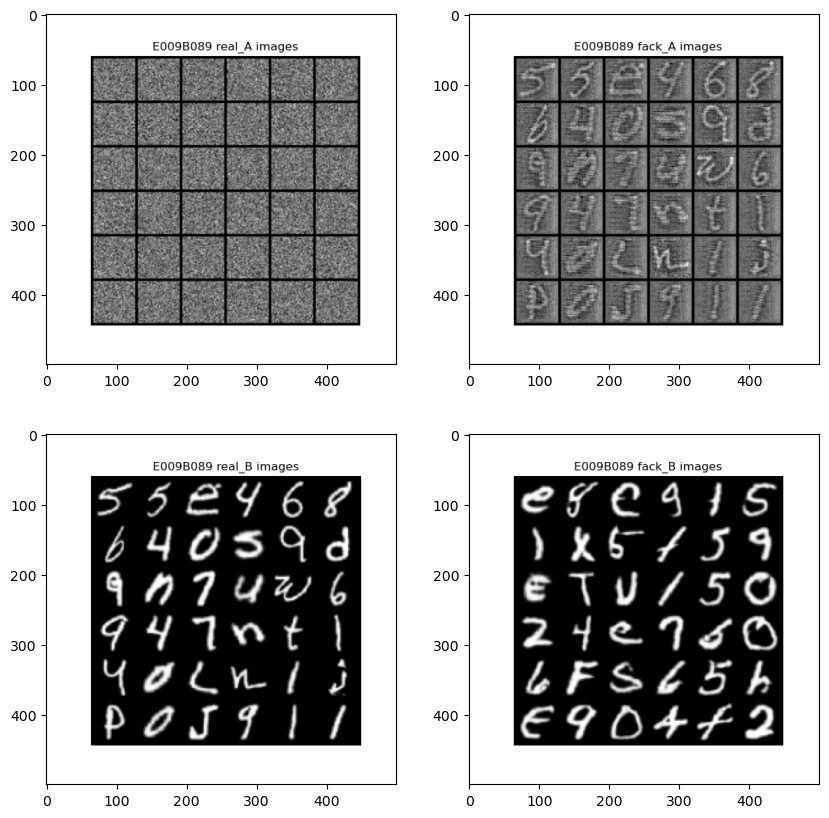

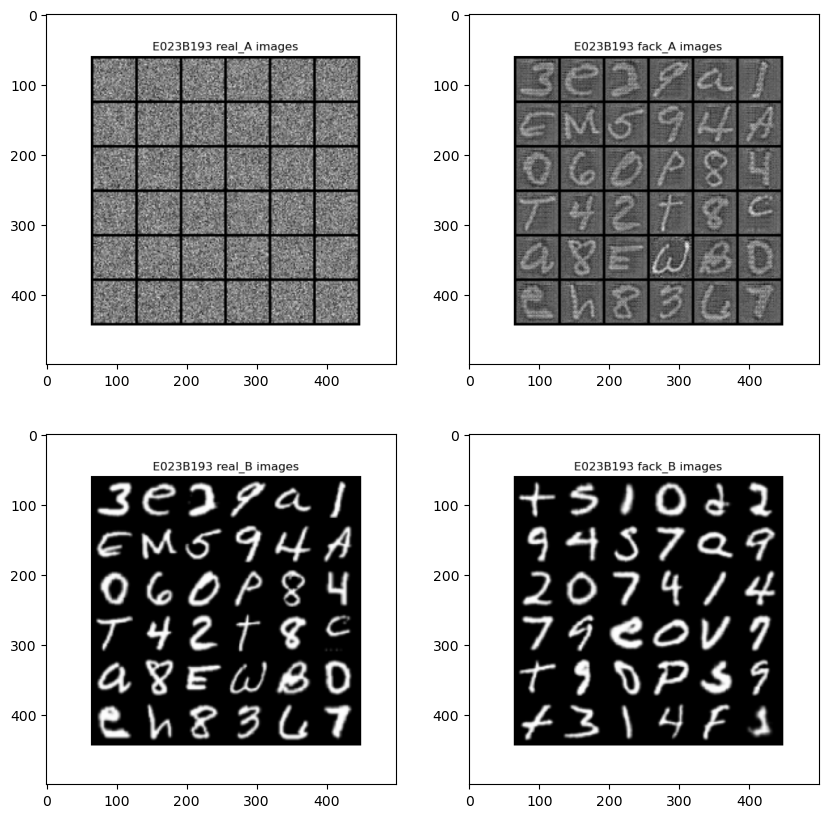

In [51]:
imgs_root = 'cycle_GAN_1/images/'
images = ['real_A', 'fack_A', 'real_B', 'fack_B']
checkpoints = ['E001B1201', 'E009B089', 'E023B193']

for checkpoint in checkpoints:
    fig = plt.figure(figsize=(10,10))
    for i, img in enumerate(images):
        path = imgs_root+checkpoint
        fake_a = plt.imread(f'{path} {img} images.png')
        plt.subplot(int(f'22{i+1}'))
        #print(fake_a[:,:,:3].shape)
        plt.imshow(fake_a)
    plt.show()

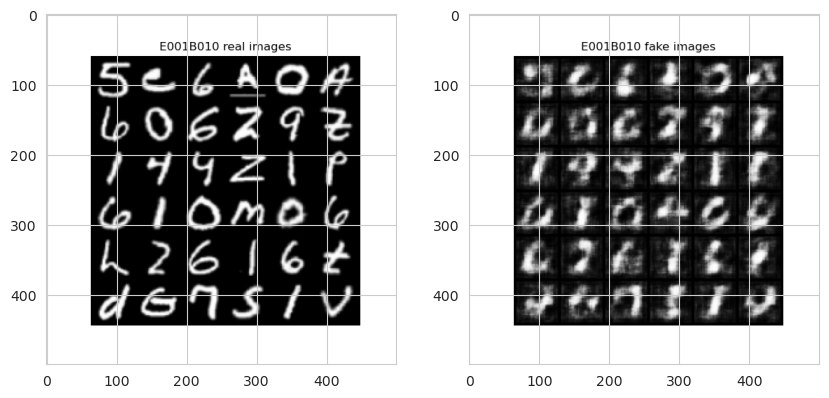

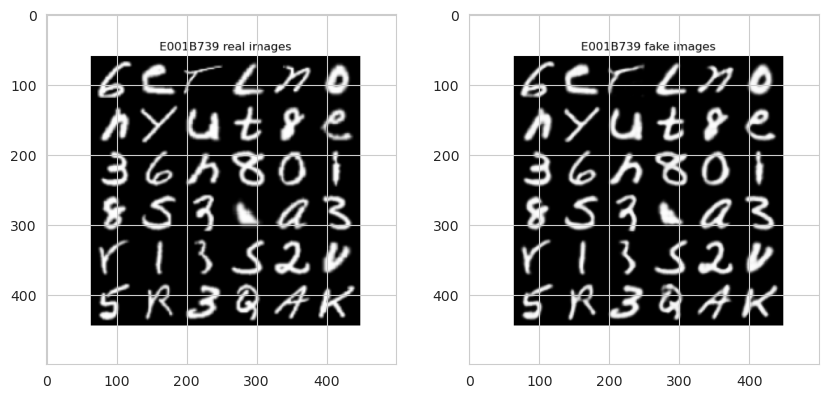

In [7]:
imgs_root = 'cycle_GAN_2/images/'
images = ['real', 'fake']
checkpoints = ['E001B010', 'E001B739']

for checkpoint in checkpoints:
    fig = plt.figure(figsize=(10,10))
    for i, img in enumerate(images):
        path = imgs_root+checkpoint
        fake_a = plt.imread(f'{path} {img} images.png')
        plt.subplot(int(f'22{i+1}'))
        #print(fake_a[:,:,:3].shape)
        plt.imshow(fake_a)
    plt.show()

In [ ]:
E001B010 real images.png